# HA-ES Plotting

- udpated version of plotting script used for paper "..."

## General

- imports
- defintions
- loading data

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygmo as pg
import seaborn as sns

import math
import os

from autorank._util import get_sorted_rank_groups
from autorank import autorank, plot_stats
from tabrepo import load_repository

method_id_name_dict = {
    "GES": "GES*",
    "SINGLE_BEST": "Single-Best",
    "QO": "QO-ES",
    "QDO": "QDO-ES",
    "ENS_SIZE_QDO": "Ensemble Size",
    "INFER_TIME_QDO": "Inference Time",
    "MEMORY_QDO": "HAPEns",
    #"MEMORY_QDO": "Memory",
    "DISK_QDO": "Diskspace",
}
infer_time_weights = np.linspace(0, 1, num=20)[1:]
infer_time_weights = np.round(infer_time_weights, 2)
multi_ges_method_ids = [f"MULTI_GES-{time_weight:.2f}" for time_weight in infer_time_weights]
multi_ges_method_names = [f"Multi-GES({time_weight:.2f})" for time_weight in infer_time_weights]
for id, name in zip(multi_ges_method_ids, multi_ges_method_names):
    method_id_name_dict[id] = name

print("Loading data. This might take a while...")
df = pd.read_csv("../data/full-overall.csv")

# Map method IDs to names
if "method" in df.columns:
    df["method_name"] = df["method"].map(method_id_name_dict)
else:
    raise ValueError("Column 'method' not found in DataFrame")
df = df.dropna(subset=['method_name'])
print(df.shape)
print(df.columns)
print(df["method_name"].unique())
print(df["method"].unique())

df["models_used_length"] = df["models_used"].apply(len)

if True:
    print("Filtering methods...")
    filter_methods = [
        "Single-Best",
        "GES*",
        "QDO-ES",
        "HAPEns",
        # "Memory",
        "Ensemble Size",
        "Inference Time",
        # "Diskspace",
        "Multi-GES(0.21)",
        "Multi-GES(0.79)"
    ]
    df = df[df['method_name'].isin(filter_methods)]
    print(df.shape)
    print(df.columns)
    print(df["method_name"].unique())
    print(df["method"].unique())

Loading data. This might take a while...
(844027, 23)
Index(['Unnamed: 0', 'name', 'roc_auc_val', 'roc_auc_test', 'models_used',
       'weights', 'task', 'dataset', 'fold', 'method', 'task_id', 'seed',
       'iteration', 'time_weight', 'inference_time', 'memory', 'diskspace',
       'normalized_roc_auc_val', 'normalized_roc_auc_test', 'normalized_time',
       'normalized_memory', 'normalized_diskspace', 'method_name'],
      dtype='object')
['Inference Time' 'QDO-ES' 'Diskspace' 'Single-Best' 'HAPEns'
 'Multi-GES(0.79)' 'Ensemble Size' 'Multi-GES(0.21)' 'GES*']
['INFER_TIME_QDO' 'QDO' 'DISK_QDO' 'SINGLE_BEST' 'MEMORY_QDO'
 'MULTI_GES-0.79' 'ENS_SIZE_QDO' 'MULTI_GES-0.21' 'GES']
Filtering methods...
(723488, 24)
Index(['Unnamed: 0', 'name', 'roc_auc_val', 'roc_auc_test', 'models_used',
       'weights', 'task', 'dataset', 'fold', 'method', 'task_id', 'seed',
       'iteration', 'time_weight', 'inference_time', 'memory', 'diskspace',
       'normalized_roc_auc_val', 'normalized_roc_au

## Helper Functions

### Boxplot:

In [13]:
import re
import ipywidgets as widgets

def extract_numeric_part(method_name):
    """
    Extracts the numeric part from a method name string. If no numeric part is found, returns None.
    """
    if isinstance(method_name, str):
        match = re.search(r"\((\d*\.?\d+)\)", method_name)
        if match:
            return float(match.group(1))
    return None

def boxplot(
    df: pd.DataFrame,
    y_str: str,
    log_y_scale: bool = False,
    log_x_scale: bool = False,
    flip_y_axis: bool = False,
    orient: str = "v",
    rotation_x_ticks: int = 45,
    outliers=False,
    sort_by_median: bool = True,  # <-- added flag
):
    if y_str not in df.columns:
        raise ValueError(f"Column '{y_str}' not found in DataFrame")
    
    df["method_name"] = df["method_name"].astype(str)

    if sort_by_median:
        # Sort by median of the target column
        medians = (
            df.groupby("method_name")[y_str]
            .median()
            .sort_values(ascending=False)  # largest median first
        )
        df["method_name"] = pd.Categorical(df["method_name"], categories=medians.index, ordered=True)
        df = df.sort_values("method_name")
    else:
        # Alphabetic + numeric sorting as fallback
        df["alphabetic"] = df["method_name"].apply(lambda x: re.split(r"\(\d*\.?\d+\)", x)[0])
        df["numeric"] = df["method_name"].apply(extract_numeric_part)
        df = df.sort_values(by=["alphabetic", "numeric"], ascending=[True, True])
        df = df.drop(columns=["alphabetic", "numeric"])

    plt.figure(figsize=(8, 6))
    if orient == "v":
        sns.boxplot(
            data=df,
            x="method_name",
            y=y_str,
            hue="method_name",
            palette="pastel",
            linewidth=2,
            orient=orient,
            legend=False,
            showfliers=outliers,
        )
    elif orient == "h":
        sns.boxplot(
            data=df,
            x=y_str,
            y="method_name",
            hue="method_name",
            palette="pastel",
            linewidth=2,
            orient=orient,
            legend=False,
            showfliers=outliers,
        )
    else:
        raise ValueError(f"Orient '{orient}' not supported")

    if orient == "v":
        plt.ylabel(y_str)
        plt.xlabel("Ensemble Method")
    else:
        plt.xlabel(y_str)
        plt.ylabel("Ensemble Method")

    if log_y_scale:
        plt.yscale("log")
    if log_x_scale:
        plt.xscale("log")
    if flip_y_axis:
        plt.gca().invert_yaxis()

    plt.xticks(rotation=rotation_x_ticks)
    plt.grid(True)
    plt.tight_layout()

    directory = "../plots"
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(f"{directory}/boxplot_{y_str}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{directory}/boxplot_{y_str}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

def interactive_boxplot(df, column_options):
    y_str_widget = widgets.Dropdown(
        options=column_options,
        description="Y-axis column:",
        style={"description_width": "initial"},
    )
    log_y_scale_widget = widgets.Checkbox(value=False, description="Log-scale Y-axis")
    log_x_scale_widget = widgets.Checkbox(value=False, description="Log-scale X-axis")
    flip_y_axis_widget = widgets.Checkbox(value=False, description="Flip Y-axis")
    orient_widget = widgets.RadioButtons(
        options=["v", "h"],
        value="h",
        description="Orientation:",
        style={"description_width": "initial"},
    )
    rotation_x_ticks_widget = widgets.IntSlider(
        value=0, min=0, max=90, step=5, description="Rotation X-ticks"
    )

    ui = widgets.VBox(
        [
            y_str_widget,
            log_y_scale_widget,
            log_x_scale_widget,
            flip_y_axis_widget,
            orient_widget,
            rotation_x_ticks_widget,
        ]
    )

    out = widgets.interactive_output(
        boxplot,
        {
            "df": widgets.fixed(df),
            "y_str": y_str_widget,
            "log_y_scale": log_y_scale_widget,
            "log_x_scale": log_x_scale_widget,
            "flip_y_axis": flip_y_axis_widget,
            "orient": orient_widget,
            "rotation_x_ticks": rotation_x_ticks_widget,
        },
    )

    display(ui, out)

### Critical Difference:

In [14]:
def cd_evaluation(
    hypervolumes,
    maximize_metric=True,
    plt_title="Critical Difference Plot",
    filename="CriticalDifferencePlot.png",
):
    """
    hypervolumes: DataFrame with method names as columns and tasks as rows, each cell contains hypervolume.
    maximize_metric: Boolean, True if higher values are better.
    output_path: Where to save the plot, if None, plot will not be saved.
    plt_title: Title of the plot.
    """
    # Prepare data
    rank_data = -hypervolumes if maximize_metric else hypervolumes

    # Run autorank
    result = autorank(rank_data, alpha=0.05, verbose=False, order="ascending")

    # Plot with updated font size
    plt.close("all")
    width = 6
    fig, ax = plt.subplots(figsize=(12, width))
    plt.rcParams.update({"font.size": 20})

    plot_stats(result, ax=ax)
    ax.tick_params(axis="both", labelsize=20)  # Set font size for axis ticks
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
    plt.tight_layout()

    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

    return result


## Data Exploration

In [15]:
column_options = ["models_used_length", "normalized_roc_auc_test", "normalized_roc_auc_val", "inference_time", "memory", "diskspace", "normalized_memory"]

#filtered_df = df[~df['method_name'].isin(['Multi-GES(0.43)', 'Multi-GES(0.50)'])].copy()
interactive_boxplot(df, column_options)

Output()

/tmp/ipykernel_65657/3229063242.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = df.groupby('method_name').agg(


<Figure size 1000x600 with 0 Axes>

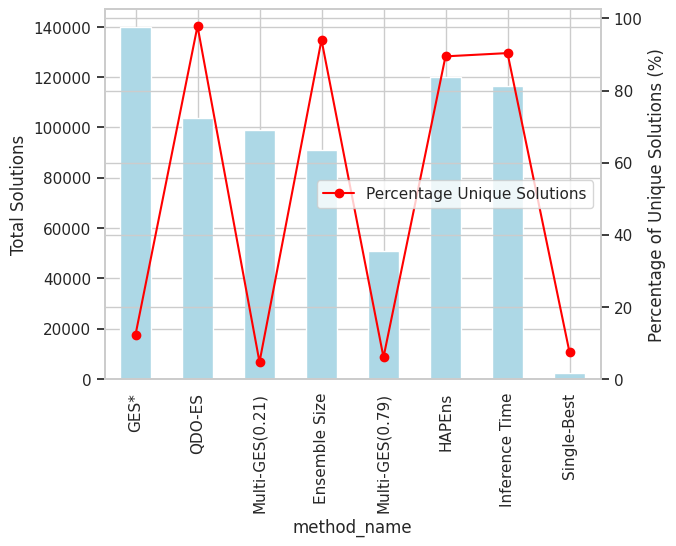

In [16]:
df['models_used_tuple'] = df['models_used'].apply(tuple)

# Group the DataFrame by 'method_name' and compute total and unique counts
result_df = df.groupby('method_name').agg(
    total_solutions=('models_used', 'count'),
    unique_solutions=('models_used_tuple', 'nunique')
)

# Calculate the percentage of unique solutions
result_df['percentage_unique_solutions'] = (
    result_df['unique_solutions'] / result_df['total_solutions'] * 100
)

# Optionally reset the index if you want 'method_name' as a column
result_df = result_df.reset_index()

# Plot the bar chart for total solutions
plt.figure(figsize=(10, 6))
ax = result_df.plot(kind='bar', x='method_name', y='total_solutions', color='lightblue', legend=False)

# Plot the percentage of unique solutions as a line graph
ax2 = ax.twinx()
ax2.plot(result_df['method_name'], result_df['percentage_unique_solutions'], color='red', marker='o', label='Percentage Unique Solutions')
ax2.set_ylabel('Percentage of Unique Solutions (%)')

# Set titles and labels
# ax.set_title("Total Solutions and Percentage of Unique Solutions per Method")
ax.set_ylabel("Total Solutions")
plt.xticks(rotation=90)
plt.legend()

plt.show()

## Pareto Front Eval

### True Pareto Front

In [17]:
def getParetoFront(df, objectives, return_mask=False):
    """
    Identify the Pareto-efficient points in the DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of objective column names.
    - return_mask: if True, return a boolean mask; else return indices.

    Returns:
    - Boolean mask or indices of Pareto-efficient points.
    """
    data = df[objectives].values
    is_efficient = np.ones(data.shape[0], dtype=bool)
    for i, c in enumerate(data):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(data[is_efficient] < c, axis=1)  # Keep any point with a lower value
            is_efficient[i] = True  # And keep self
    if return_mask:
        return is_efficient
    else:
        return np.where(is_efficient)[0]
    
def calculate_pareto_fronts(df, objectives):
    """
    Calculate the Pareto front points for all solutions in the DataFrame per task_id, seed, and fold.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of two objective column names.

    Returns:
    - A nested dictionary with structure {task_id: {seed: {fold: pareto_front_df}}}
    """
    if len(objectives) != 2:
        raise ValueError("Exactly two objectives must be provided.")

    # Initialize a dictionary to store the Pareto fronts
    pareto_fronts = {}

    # Iterate over unique task_ids
    for task_id in df["task_id"].unique():
        pareto_fronts[task_id] = {}

        # Iterate over unique seeds
        for seed in df["seed"].unique():
            pareto_fronts[task_id][seed] = {}

            # Iterate over unique folds
            for fold in df["fold"].unique():
                # Filter the DataFrame for the current task_id, seed, and fold
                df_fold = df[
                    (df["task_id"] == task_id)
                    & (df["seed"] == seed)
                    & (df["fold"] == fold)
                ]

                if df_fold.empty:
                    continue  # Skip if no data for this combination

                # Compute Pareto front for df_fold
                is_efficient = getParetoFront(df_fold, objectives, return_mask=True)
                pareto_front_df = df_fold[is_efficient]

                # Store the Pareto front DataFrame
                pareto_fronts[task_id][seed][fold] = pareto_front_df

    return pareto_fronts

In [18]:
from process_data import normalize_data

hw_score = 'hw_score'
perf_metric = 'normalized_roc_auc_test'
hw_metrics = ['normalized_time', 'normalized_memory', 'normalized_diskspace']

df['hw_score'] = df[hw_metrics].mean(axis=1)
for task in df["task"].unique():
    mask = df["task"] == task
    if "hw_score" in df.columns:
        df.loc[mask, "normalized_hw_score"] = normalize_data(
            df.loc[mask, "hw_score"]
        )
hw_metrics.append('normalized_hw_score')

metric_pairs = [(perf_metric, hw_metric) for hw_metric in hw_metrics]
print(metric_pairs)

[('normalized_roc_auc_test', 'normalized_time'), ('normalized_roc_auc_test', 'normalized_memory'), ('normalized_roc_auc_test', 'normalized_diskspace'), ('normalized_roc_auc_test', 'normalized_hw_score')]


### Hypervolume

In [19]:
def is_pareto_efficient(costs, return_mask=True):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        is_efficient[i] = not np.any(
            np.all(costs <= c, axis=1) & np.any(costs < c, axis=1)
        )
    return is_efficient if return_mask else costs[is_efficient]


def calculate_average_hypervolumes(df, method_name, objectives: list):
    if len(objectives) != 2: 
        return
    df_method = df[df["method_name"] == method_name]
    hypervolumes = {}

    # Iterate over unique task_ids
    for task_id in df_method["task_id"].unique():
        seed_hypervolumes = []  # Store hypervolumes for each seed

        for seed in df_method["seed"].unique():
            fold_hypervolumes = []  # Store hypervolumes for each fold under the current seed

            for fold in df_method["fold"].unique():
                df_fold = df_method[
                    (df_method["task_id"] == task_id)
                    & (df_method["seed"] == seed)
                    & (df_method["fold"] == fold)
                ]

                # Use a different variable name here
                objective_values = np.array(
                    [
                        df_fold[objectives[0]].values,
                        df_fold[objectives[1]].values,
                    ]
                ).T
                is_efficient = is_pareto_efficient(objective_values)
                efficient_objectives = objective_values[is_efficient]

                ref_point = [
                    1.01,
                    1.01,
                ]  # Reference point beyond the worst values of objectives
                hv = pg.hypervolume(efficient_objectives)
                hypervolume = hv.compute(ref_point)
                fold_hypervolumes.append(hypervolume)

            # Average hypervolumes across all folds for a given seed
            if fold_hypervolumes:
                average_fold_hypervolume = np.mean(fold_hypervolumes)
                seed_hypervolumes.append(average_fold_hypervolume)

        # Average the averaged fold hypervolumes across seeds
        if seed_hypervolumes:
            average_seed_hypervolume = np.mean(seed_hypervolumes)
            hypervolumes[task_id] = average_seed_hypervolume

    return hypervolumes


def find_non_dominated(points):
    """Identify the indices of non-dominated points."""
    is_efficient = np.ones(points.shape[0], dtype=bool)
    for i, c in enumerate(points):
        is_efficient[i] = not np.any(
            np.all(points <= c, axis=1) & np.any(points < c, axis=1)
        )
    return np.where(is_efficient)[0]


def plot_hypervolumes(all_hypervolumes, title: str, directory: str = "../plots/"):
    # Prepare the data for plotting
    methods = list(all_hypervolumes.keys())  # Method names
    hv_values = [list(all_hypervolumes[method].values()) for method in methods]
    data = []

    # Creating a DataFrame suitable for Seaborn
    for method_index, values in enumerate(hv_values):
        for value in values:
            data.append({"Method": methods[method_index], "Hypervolume": value})
    df = pd.DataFrame(data)

    # Calculate medians for each method and sort by median
    median_order = df.groupby("Method")["Hypervolume"].median().sort_values(ascending=False).index

    # Set the figure size and style
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Use seaborn's boxplot to plot the DataFrame, ordered by median values
    ax = sns.boxplot(
        y="Method", x="Hypervolume", data=df, hue="Method", palette="Set2",
        orient="h", order=median_order
    )

    # Set titles and labels
    ax.set_ylabel("Method", fontsize=20)
    ax.set_xlabel("Hypervolume", fontsize=20)

    # Set font size for ticks
    ax.tick_params(axis="x", labelrotation=45, labelsize=16)
    ax.tick_params(axis="y", labelsize=16)

    plt.tight_layout()
    plt.savefig(directory + title + ".png", dpi=300)
    plt.savefig(directory + title + ".pdf", dpi=300)
    plt.show()
    plt.close()


--- Processing pair: ('normalized_roc_auc_test', 'normalized_time') ---


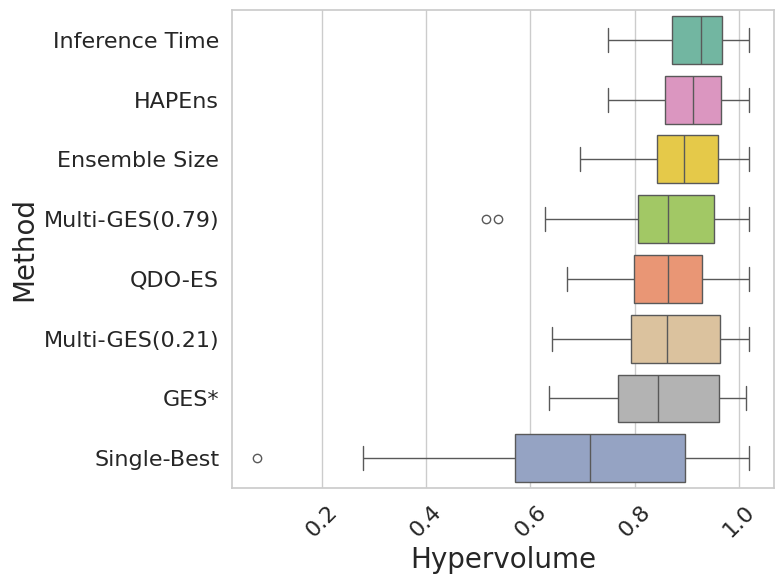

Saved hypervolume data to ../data/hypervolumes_normalized_roc_auc_test_normalized_time.csv
                 meanrank    median       mad  ci_lower  ci_upper effect_size  \
Inference Time   2.204819 -0.926729    0.0503  -0.96298 -0.876428         0.0   
HAPEns           2.578313 -0.912465  0.054837 -0.950027 -0.863016   -0.182837   
Ensemble Size    3.903614 -0.895339  0.057391 -0.946841 -0.844809   -0.392353   
Multi-GES(0.21)  4.445783 -0.861301  0.094605 -0.955906 -0.804009   -0.582477   
Multi-GES(0.79)  4.469880 -0.864041  0.085001 -0.945431 -0.813181   -0.605417   
GES*             5.379518 -0.843929  0.103222 -0.927931 -0.781516   -0.687826   
QDO-ES           5.469880 -0.864004  0.064714 -0.908235 -0.801369   -0.729982   
Single-Best      7.548193 -0.713415  0.178279 -0.879489 -0.607862   -1.098444   

                  magnitude effect_size_above magnitude_above  
Inference Time   negligible               0.0      negligible  
HAPEns           negligible         -0.182837      

/tmp/ipykernel_65657/1923523148.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_65657/1923523148.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


Saved critical difference plots for ('normalized_roc_auc_test', 'normalized_time')

--- Processing pair: ('normalized_roc_auc_test', 'normalized_memory') ---


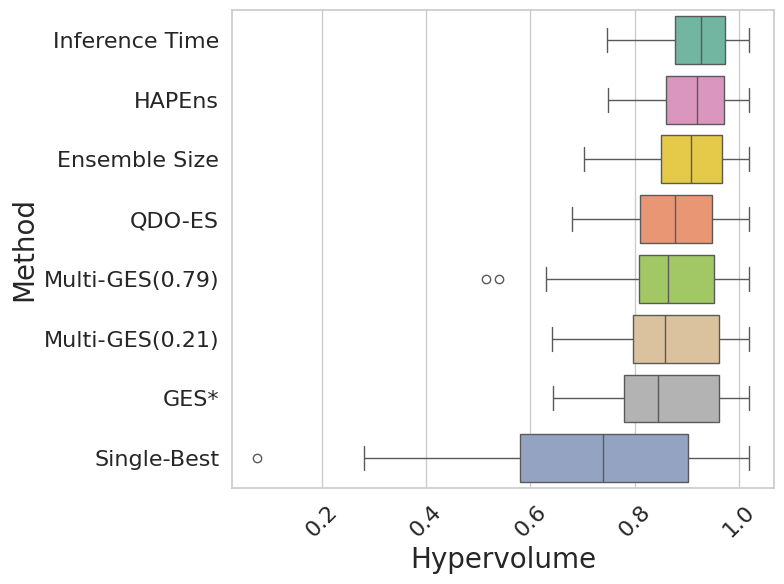

Saved hypervolume data to ../data/hypervolumes_normalized_roc_auc_test_normalized_memory.csv
                 meanrank    median       mad  ci_lower  ci_upper effect_size  \
Inference Time   2.216867 -0.927524  0.048484 -0.963464  -0.87904         0.0   
HAPEns           2.542169 -0.919069  0.054224 -0.957786 -0.871346   -0.110877   
Ensemble Size    3.795181 -0.907643  0.059213 -0.949598 -0.852209   -0.247795   
Multi-GES(0.21)  4.710843 -0.857627  0.096257 -0.955341  -0.81331   -0.618612   
Multi-GES(0.79)  4.957831 -0.864215  0.084295 -0.945612 -0.815632   -0.621004   
QDO-ES           5.000000 -0.877945  0.067327 -0.936604 -0.817334   -0.570008   
GES*             5.150602 -0.844815  0.085177 -0.929992 -0.786361   -0.804964   
Single-Best      7.626506 -0.738667  0.165616 -0.881789 -0.607953   -1.043915   

                  magnitude effect_size_above magnitude_above  
Inference Time   negligible               0.0      negligible  
HAPEns           negligible         -0.110877    

/tmp/ipykernel_65657/1923523148.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_65657/1923523148.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


Saved critical difference plots for ('normalized_roc_auc_test', 'normalized_memory')

--- Processing pair: ('normalized_roc_auc_test', 'normalized_diskspace') ---


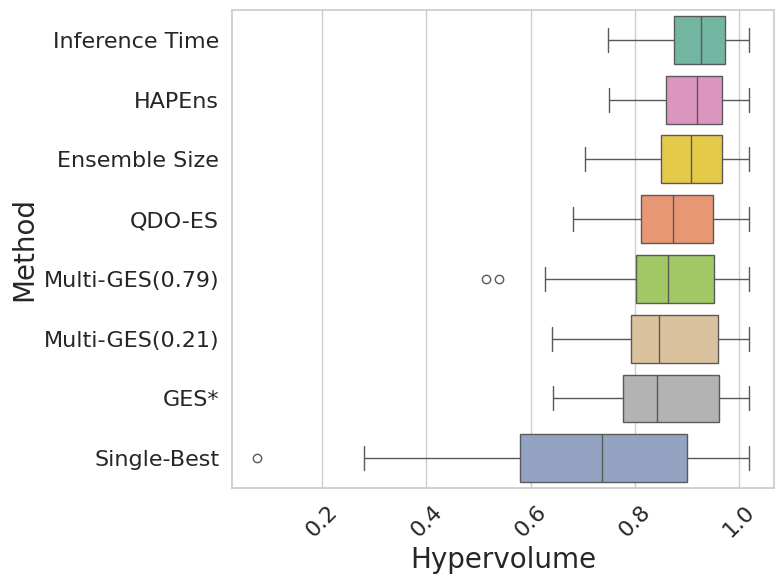

Saved hypervolume data to ../data/hypervolumes_normalized_roc_auc_test_normalized_diskspace.csv
                 meanrank    median       mad  ci_lower  ci_upper effect_size  \
Inference Time   2.012048 -0.927363  0.048449 -0.964429 -0.879575         0.0   
HAPEns           2.385542 -0.919089  0.054274 -0.957925 -0.871841   -0.108494   
Ensemble Size    3.590361 -0.907971  0.059637  -0.95014 -0.853142    -0.24074   
QDO-ES           4.987952 -0.873531  0.064251 -0.936415  -0.81329    -0.63811   
Multi-GES(0.21)  5.048193 -0.847259  0.105108 -0.952637 -0.810905     -0.6602   
Multi-GES(0.79)  5.192771 -0.864019  0.083686  -0.94463 -0.811666    -0.62485   
GES*             5.307229 -0.841889  0.089742 -0.931631 -0.786085    -0.79945   
Single-Best      7.475904 -0.736742  0.165732 -0.881789 -0.606872   -1.053048   

                  magnitude effect_size_above magnitude_above  
Inference Time   negligible               0.0      negligible  
HAPEns           negligible         -0.108494 

/tmp/ipykernel_65657/1923523148.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_65657/1923523148.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


Saved critical difference plots for ('normalized_roc_auc_test', 'normalized_diskspace')

--- Processing pair: ('normalized_roc_auc_test', 'normalized_hw_score') ---


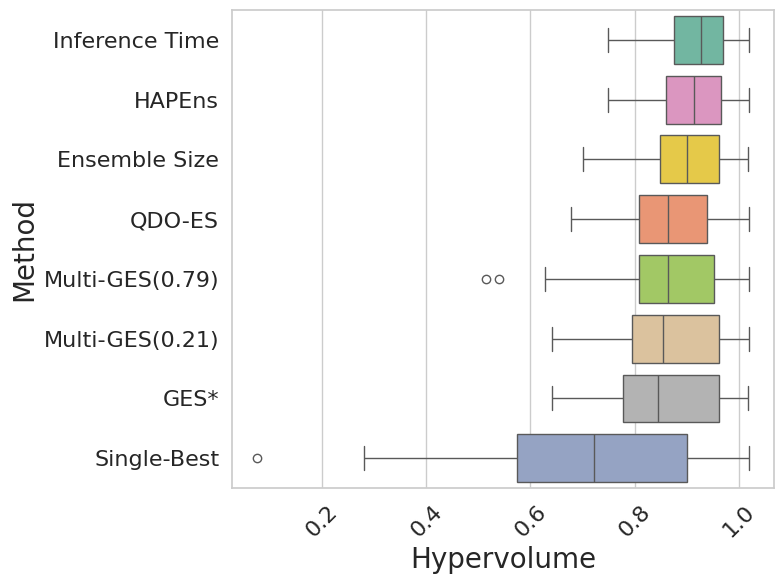

Saved hypervolume data to ../data/hypervolumes_normalized_roc_auc_test_normalized_hw_score.csv
                 meanrank    median       mad  ci_lower  ci_upper effect_size  \
Inference Time   2.180723 -0.927230  0.049449 -0.959935  -0.87778         0.0   
HAPEns           2.518072 -0.914688     0.054 -0.953085 -0.866701   -0.163383   
Ensemble Size    3.891566 -0.899516  0.059228 -0.943787 -0.849235   -0.342615   
Multi-GES(0.21)  4.560241 -0.853840  0.099975 -0.955286 -0.811955   -0.627643   
Multi-GES(0.79)  4.728916 -0.864058  0.084878 -0.945585 -0.814841   -0.613429   
GES*             5.210843 -0.844163  0.098594 -0.931875 -0.784834   -0.718358   
QDO-ES           5.313253 -0.864317  0.062297 -0.920269 -0.813732   -0.754495   
Single-Best      7.596386 -0.721852  0.176106 -0.881533   -0.6082   -1.071003   

                  magnitude effect_size_above magnitude_above  
Inference Time   negligible               0.0      negligible  
HAPEns           negligible         -0.163383  

/tmp/ipykernel_65657/1923523148.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_65657/1923523148.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


In [20]:
for perf_metric, hw_metric in metric_pairs:
    metric_pair = (perf_metric, hw_metric)
    print(f"\n--- Processing pair: {metric_pair} ---")

    methods = df["method_name"].unique()
    all_hypervolumes = {}

    for method in methods:
        all_hypervolumes[method] = calculate_average_hypervolumes(df, method, metric_pair)

    # You might want to make this plot function also save to a dynamic filename
    plot_hypervolumes(all_hypervolumes, f"bp_hv_{perf_metric}_{hw_metric}")

    # Create dynamic filenames to avoid overwriting results
    csv_filename = f"../data/hypervolumes_{perf_metric}_{hw_metric}.csv"
    plot_filename_pdf = f"../plots/CDP_HV_{perf_metric}_{hw_metric}.pdf"
    plot_filename_png = f"../plots/CDP_HV_{perf_metric}_{hw_metric}.png"

    hypervolumes_df = pd.DataFrame(all_hypervolumes)
    hypervolumes_df.to_csv(csv_filename, index=False)
    print(f"Saved hypervolume data to {csv_filename}")

    data = []
    for method, task_ids in all_hypervolumes.items():
        for task_id, hypervolume in task_ids.items():
            data.append({"Task": task_id, "Method": method, "Hypervolume": hypervolume})

    df_hypervolumes = pd.DataFrame(data)
    pivot_hypervolumes = df_hypervolumes.pivot(
        index="Task", columns="Method", values="Hypervolume"
    )

    # Run CD evaluation with dynamic filenames
    hv_result = cd_evaluation(
        pivot_hypervolumes,
        maximize_metric=True,
        plt_title=f"Hypervolume CD Plot for {perf_metric} vs {hw_metric}",
        filename=plot_filename_pdf,
    )
    hv_result = cd_evaluation(
        pivot_hypervolumes,
        maximize_metric=True,
        plt_title=f"Hypervolume CD Plot for {perf_metric} vs {hw_metric}",
        filename=plot_filename_png,
    )
    print(f"Saved critical difference plots for {metric_pair}")
    # print(hv_result)

print("\n--- Analysis complete for all pairs. ---")

### Inverted Generational Distance

In [21]:
from pymoo.indicators.igd import IGD

def calculate_IGD_per_method(df, objectives):
    """
    Calculate the IGD for each method_name per task_id, seed, and fold.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of two objective column names.

    Returns:
    - DataFrame with columns [task_id, seed, fold, method_name, IGD].
    """
    results = []

    # Iterate over unique task_ids
    for task_id in df["task_id"].unique():
        # Iterate over unique seeds
        for seed in df["seed"].unique():
            # Iterate over unique folds
            for fold in df["fold"].unique():
                # Filter the DataFrame for the current task_id, seed, and fold
                df_fold = df[
                    (df["task_id"] == task_id)
                    & (df["seed"] == seed)
                    & (df["fold"] == fold)
                ]

                if df_fold.empty:
                    continue  # Skip if no data for this combination

                # Compute the reference Pareto front (from all methods)
                is_efficient = getParetoFront(df_fold, objectives, return_mask=True)
                reference_pareto_front = df_fold[is_efficient]
                pf_points = reference_pareto_front[objectives].values

                # Iterate over unique method_names
                for method_name in df_fold["method_name"].unique():
                    df_method = df_fold[df_fold["method_name"] == method_name]

                    # Compute Pareto front for df_method
                    is_efficient = getParetoFront(df_method, objectives, return_mask=True)
                    method_pareto_front = df_method[is_efficient]
                    method_points = method_pareto_front[objectives].values

                    if len(method_points) == 0 or len(pf_points) == 0:
                        igd_value = np.nan
                    else:
                        # Calculate IGD
                        ind = IGD(pf_points)
                        igd_value = ind(method_points)

                    # Append results
                    results.append({
                        "task_id": task_id,
                        "seed": seed,
                        "fold": fold,
                        "method_name": method_name,
                        "IGD": igd_value
                    })

    return pd.DataFrame(results)


def plot_IGD_values_with_medians(igd_results):
    """
    Plot the IGD values for each method, sorted by median IGD, and annotate the median values on the plot.

    Parameters:
    - igd_results: DataFrame with columns [task_id, seed, fold, method_name, IGD].
    """
    # Remove any NaN IGD values
    igd_results_clean = igd_results.dropna(subset=['IGD'])

    # Compute median IGD per method and sort methods
    median_igd = igd_results_clean.groupby('method_name')['IGD'].median().sort_values()
    sorted_methods = median_igd.index.tolist()

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=igd_results_clean, x='method_name', y='IGD', order=sorted_methods)
    
    # Annotate median values on top of the box plots
    for method in sorted_methods:
        median_val = median_igd[method]
        x = sorted_methods.index(method)  # Find the position on the x-axis
        y = median_val
        ax.text(x, y + 0.01, f'{median_val:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

    plt.title('IGD Values per Method (Sorted by Median IGD)')
    plt.ylabel('IGD')
    plt.xlabel('Method Name')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [22]:
# Calculate IGD per method
igd_results = calculate_IGD_per_method(df, objectives)

# Plot IGD values per method, sorted by median IGD, and annotate median values
plot_IGD_values_with_medians(igd_results)


NameError: name 'objectives' is not defined

In [ ]:
# Group by 'method_name' and 'task_id', and aggregate with 'sum'
agg_igd = igd_results.groupby(["method_name", "task_id"]).agg('sum').reset_index()

# Pivot the data to have 'task_id' as the index and 'method_name' as columns
igd_pivots = agg_igd.pivot(
    index="task_id", columns="method_name", values="IGD"
)

# Perform the critical difference evaluation
igd_result = cd_evaluation(
    igd_pivots,
    maximize_metric=False,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDP_IGD.png",
)

# Repeat the same evaluation if necessary
igd_result = cd_evaluation(
    igd_pivots,
    maximize_metric=False,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDP_IGD.pdf",
)

### Pareto Front Topography

In [ ]:
# Get unique method names
method_names = df["method_name"].unique()

# Calculate Pareto fronts for each method
method_pareto_fronts = {}
for method in method_names:
    df_method = df[df["method_name"] == method]
    method_pareto_fronts[method] = calculate_pareto_fronts(df_method, objectives)

# Function to count the number of solutions in Pareto fronts
def count_pareto_solutions(pareto_fronts):
    counts = {}
    for task_id in pareto_fronts:
        for seed in pareto_fronts[task_id]:
            for fold in pareto_fronts[task_id][seed]:
                pareto_front_df = pareto_fronts[task_id][seed][fold]
                n_solutions = len(pareto_front_df)
                key = (task_id, seed, fold)
                counts[key] = n_solutions
    return counts

# Count solutions in the method-specific Pareto fronts
method_pareto_counts = {}
for method in method_names:
    method_pareto_counts[method] = count_pareto_solutions(method_pareto_fronts[method])

# Calculate total number of solutions per method, task_id, seed, fold
total_counts = df.groupby(['method_name', 'task_id', 'seed', 'fold']).size().reset_index(name='total_solutions')

# Prepare data for plotting counts
data_list = []

# Add the method-specific Pareto fronts and total counts
for method in method_names:
    counts = method_pareto_counts[method]
    for key, n_solutions in counts.items():
        task_id, seed, fold = key
        # Get total number of solutions for this method, task_id, seed, fold
        total_solutions = total_counts[
            (total_counts['method_name'] == method) &
            (total_counts['task_id'] == task_id) &
            (total_counts['seed'] == seed) &
            (total_counts['fold'] == fold)
        ]['total_solutions'].values[0]
        data_list.append({
            'method_name': method,
            'task_id': task_id,
            'seed': seed,
            'fold': fold,
            'n_pareto_solutions': n_solutions,
            'total_solutions': total_solutions
        })

pareto_counts_df = pd.DataFrame(data_list)
pareto_counts_df['proportion_pareto'] = pareto_counts_df['n_pareto_solutions'] / pareto_counts_df['total_solutions']


# Calculate the average number of Pareto solutions per method
avg_pareto_solutions = pareto_counts_df.groupby('method_name')['n_pareto_solutions'].mean().reset_index()

# Calculate the average total number of solutions per method
avg_total_solutions = pareto_counts_df.groupby('method_name')['total_solutions'].mean().reset_index()

# Merge the averages into a single DataFrame
avg_counts_df = pd.merge(avg_pareto_solutions, avg_total_solutions, on='method_name')

# Sort methods by average total solutions for better visualization
avg_counts_df = avg_counts_df.sort_values('total_solutions')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot average number of Pareto solutions
sns.barplot(
    data=avg_counts_df,
    x='method_name',
    y='n_pareto_solutions',
    ax=axes[0],
    palette='Blues_d'
)
axes[0].set_title('Average Number of Pareto Solutions per Method')
axes[0].set_xlabel('Method Name')
axes[0].set_ylabel('Average Number of Pareto Solutions')
axes[0].tick_params(axis='x', rotation=90)

# Plot average total number of solutions
sns.barplot(
    data=avg_counts_df,
    x='method_name',
    y='total_solutions',
    ax=axes[1],
    palette='Greens_d'
)
axes[1].set_title('Average Total Number of Solutions per Method')
axes[1].set_xlabel('Method Name')
axes[1].set_ylabel('Average Total Number of Solutions')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


### Proportion of Solutions on the Global Pareto Front

The following plot illustrates the effectiveness of each method in generating solutions that are part of the global Pareto front. For each task, the global Pareto front is determined by considering all solutions from all methods. We then calculate the proportion of each method's generated solutions that lie on this global front. A higher proportion indicates that a method is more efficient at finding globally optimal solutions.

In [ ]:
import matplotlib.ticker as mtick

print("Preparing data for per-task and per-seed analysis...")
df_main = df.copy()
task_column_name = 'task'

cost_metrics = ['normalized_time', 'normalized_memory', 'normalized_diskspace']
unique_tasks = df_main[task_column_name].unique()
unique_seeds = df_main['seed'].unique()
all_proportions = []

# Loop over each task
for task in unique_tasks:
    # --- CHANGE: Added inner loop to iterate over each seed ---
    for seed in unique_seeds:
        # Filter for the specific task and seed combination
        df_task_seed = df_main[(df_main[task_column_name] == task) & (df_main['seed'] == seed)].copy()

        # If there's no data for this combination, skip to the next
        if df_task_seed.empty:
            continue

        # Get total solutions for this specific task-seed combo
        total_solutions_task_seed = df_task_seed.groupby('method_name', observed=True).size()

        for metric in cost_metrics:
            objectives = ['normalized_roc_auc_test', metric]
            pf_col_name = f'is_on_pf_{metric}'
            df_task_seed[pf_col_name] = False

            # Calculate Pareto front for each fold within this task and seed
            global_pareto_indices = []
            # --- CHANGE: Grouping is now only by 'fold' ---
            for name, group in df_task_seed.groupby(['fold']):
                if not group.empty:
                    is_efficient_mask = getParetoFront(group, objectives, return_mask=True)
                    global_pareto_indices.extend(group[is_efficient_mask].index)

            # Ensure we only use unique indices
            df_task_seed.loc[list(set(global_pareto_indices)), pf_col_name] = True

            # Calculate proportions for each method within this task-seed combo
            solutions_on_pf = df_task_seed.groupby('method_name', observed=True)[pf_col_name].sum()
            task_seed_proportions = (solutions_on_pf / total_solutions_task_seed).fillna(0)

            # Store the results for this task-seed combo
            for method_name, proportion in task_seed_proportions.items():
                all_proportions.append({
                    task_column_name: task,
                    'seed': seed, # Also store the seed
                    'method_name': method_name,
                    'metric_type': metric.replace('_', ' ').replace('normalized', '').strip().capitalize(),
                    'proportion': proportion,
                    'num_solutions': total_solutions_task_seed.get(method_name, 0)
                })

print("Averaging the per-task-seed results...")
per_task_seed_df = pd.DataFrame(all_proportions)

# Filter out the 'Single-Best' method if it exists
if 'Single-Best' in per_task_seed_df['method_name'].unique():
    per_task_seed_df = per_task_seed_df[per_task_seed_df['method_name'] != 'Single-Best']

# Forcefully remove the unused 'Single-Best' category to fix plotting issues
if isinstance(per_task_seed_df['method_name'].dtype, pd.CategoricalDtype):
    per_task_seed_df['method_name'] = per_task_seed_df['method_name'].cat.remove_unused_categories()

# Determine the final sort order based on the new, more granular mean
sort_order_df = per_task_seed_df.groupby('method_name', observed=True)['proportion'].mean().sort_values(ascending=False)
sort_order = sort_order_df.index.tolist()
# Note: n is now the average number of solutions per task-seed combination
avg_solutions_per_method = per_task_seed_df.groupby('method_name')['num_solutions'].mean()

print("Generating the final plot...")
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=per_task_seed_df,
    y='method_name',
    x='proportion',
    hue='metric_type',
    order=sort_order,
    palette='viridis',
    errorbar='se'
)

new_yticklabels = []
for method in sort_order:
    avg_sol = avg_solutions_per_method.get(method, 0)
    # The label now reflects that 'n' is the avg per task-seed run
    new_yticklabels.append(f"{method}\n(n={avg_sol:.1f})")

ax.set_yticklabels(new_yticklabels)

# Apply formatting
ax.set_xlabel('Average Per-Task Ensemble Proportion on Global Pareto Front', fontsize=18)
ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.legend(title='Cost Metric', fontsize=14, title_fontsize=16)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

directory = "../plots"
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(f"{directory}/proportion_on_global_pf_per_task_seed_avg.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{directory}/proportion_on_global_pf_per_task_seed_avg.pdf", dpi=300, bbox_inches="tight")

plt.show()

## Ensemble Construction Behavior

In [ ]:
objectives_to_plot = ['normalized_roc_auc_test', 'normalized_time']

# --- Performance: Subsample the data ---
n_samples = 3000000
if len(df) > n_samples:
    print(f"Dataset is large. Using a random sample of {n_samples} points for speed.")
    df_sample = df.sample(n=n_samples, random_state=42)
else:
    df_sample = df

# --- Subplot Grid Setup ---
method_names = sorted(df_sample['method_name'].unique()) # Sort names for consistent order
num_methods = len(method_names)

grid_cols = math.ceil(math.sqrt(num_methods))
grid_rows = math.ceil(num_methods / grid_cols)

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(
    grid_rows, 
    grid_cols, 
    figsize=(20, 18), 
    sharex=True, 
    sharey=True
)
axes = axes.flatten()

print("Generating final polished density plots...")

# --- Loop through each method and create its subplot ---
for i, method in enumerate(method_names):
    ax = axes[i]
    df_method_sample = df_sample[df_sample['method_name'] == method]
    
    sns.kdeplot(
        data=df_method_sample,
        x=objectives_to_plot[0],
        y=objectives_to_plot[1],
        fill=True,
        alpha=0.5,
        color='c',
        levels=7,
        ax=ax
    )
    
    sns.kdeplot(
        data=df_method_sample,
        x=objectives_to_plot[0],
        y=objectives_to_plot[1],
        fill=False,
        linewidths=1.0,
        color='teal',
        levels=7,
        ax=ax
    )
    
    ax.set_title(method, fontsize=18, pad=12)

# --- Final Touches ---
for i in range(num_methods, len(axes)):
    ax = axes[i]
    ax.set_frame_on(False) # Make frame invisible
    ax.get_yaxis().set_visible(False) # Hide Y axis objects
    ax.spines['bottom'].set_visible(False) # Hide the x-axis line
    ax.tick_params(bottom=False) # Hide the x-axis tick marks

# Set common labels and a title for the entire figure
fig.supxlabel('Normalized Test ROC AUC', fontsize=22, y=0.07)
fig.supylabel('Normalized Inference Time', fontsize=22, x=0.08)
fig.suptitle('Density of Ensembles Constructed by Method', fontsize=28, y=0.97)

# --- CHANGE: Add buffer to xlim/ylim to fix overlapping zero labels ---
plt.setp(axes, xlim=(-0.02, 1.02), ylim=(-0.02, 1.02))

# Increase tick label size and clear individual labels
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=16)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0.09, 0.08, 1, 0.94])

plt.show()

## Latex Table

In [ ]:
def create_latex_table(df, repo, filename="table.tex", max_char=15):
    methods = df["method_name"].unique()
    task_ids = df["task_id"].unique()

    with open(filename, "w") as f:
        f.write("\\begin{longtable}{l" + "c" * len(methods) + "}\n")
        f.write(
            "\\caption{Test ROC AUC - Binary: The mean and standard deviation of the test score over all folds for each method. The best methods per dataset are shown in bold. All methods close to the best method are considered best (using NumPy’s default \\texttt{isclose} function).}\n"
        )
        f.write("\\label{tab:results} \\\\ \n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endfirsthead\n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endhead\n")
        f.write("\\midrule\n")
        f.write(
            "\\multicolumn{"
            + str(len(methods) + 1)
            + "}{r}{Continued on next page} \\\\\n"
        )
        f.write("\\midrule\n")
        f.write("\\endfoot\n")
        f.write("\\bottomrule\n")
        f.write("\\endlastfoot\n")

        for task_id in task_ids:
            dataset_name = repo.tid_to_dataset(
                task_id
            )  # Convert task_id to dataset name
            truncated_name = (
                (dataset_name[:max_char] + "...")
                if len(dataset_name) > max_char
                else dataset_name
            )
            escaped_name = truncated_name.replace("_", "\\_")  # Escape underscores
            line = [str(escaped_name)]  # Ensure the first item is a string
            method_scores = []

            for method in methods:
                method_data = df[
                    (df["task_id"] == task_id) & (df["method_name"] == method)
                ]
                if not method_data.empty:
                    mean_score = method_data["roc_auc_test"].mean()
                    std_dev = method_data["roc_auc_test"].std()
                    score_str = f"{mean_score:.4f}($\\pm${std_dev:.4f})"
                    method_scores.append((mean_score, score_str))
                else:
                    method_scores.append((None, "-"))

            # Determine the best score
            best_score = max(
                score[0] for score in method_scores if score[0] is not None
            )

            for mean_score, score_str in method_scores:
                if mean_score is not None and np.isclose(mean_score, best_score):
                    line.append(f"\\textbf{{{score_str}}}")
                else:
                    line.append(score_str)

            f.write(" & ".join(line) + " \\\\\n")

        f.write("\\bottomrule\n")
        f.write("\\end{longtable}\n")

In [ ]:
directory = "../tables"
if not os.path.exists(directory):
    os.makedirs(directory)

repo = load_repository("D244_F3_C1530_100", cache=True)
create_latex_table(df, repo, filename="../tables/table.tex")